# PDE Examples

In [1]:
import sys
sys.path.append("..")
from fireframe.ff.PDESystem import *
from fireframe.ff.PDESubsystem import *


%load_ext autoreload
%autoreload 2

In [ ]:
class pde_solver(PDESystem):
    def __init__(self, comp, mesh, parameters):
        PDESystem.__init__(self, comp, mesh, parameters)

    def setup_bcs(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        
        bcu = [fd.DirichletBC(self.V['u'], fd.Constant((0,0)), (1, 4)), # top-bottom and cylinder
          fd.DirichletBC(self.V['u'], ((4.0*1.5*y*(0.41 - y) / 0.41**2) ,0), 2)] # inflow
        bcp = [fd.DirichletBC(self.V['p'], fd.Constant(0), 3)]  # outflow
        
        self.bc['up'] = [bcu, bcp, None]
        self.bc['c'] = [None]
        
    def define(self, name, var_seq, bcs, forms_cnt):
        self.pdesubsystems[name] = self.subsystem[name](vars(self), var_seq, name, bcs, forms_cnt)


class navier_stokes(PDESubsystem):
        
    def form1(self, u_trl, u_tst, u_n, p_n, **kwargs):
        n = fd.FacetNormal(self.mesh)
        k = fd.Constant(self.prm['dt'])
        f = fd.Constant((0.0, 0.0))
        nu = fd.Constant(0.001)
        
        def sigma(u, p):
            return 2*nu*fd.sym(fd.nabla_grad(u)) - p*fd.Identity(len(u))

        u_mid = 0.5 * (u_n + u_trl)

        Form = fd.inner((u_trl - u_n)/k, u_tst) * fd.dx \
        + fd.inner(fd.dot(u_n, fd.nabla_grad(u_mid)), u_tst) * fd.dx \
        + fd.inner(sigma(u_mid, p_n), fd.sym(fd.nabla_grad(u_tst))) * fd.dx \
        + fd.inner(p_n * n, u_tst) * fd.ds \
        - fd.inner(nu * fd.dot(fd.nabla_grad(u_mid), n), u_tst) * fd.ds \
        - fd.inner(f, u_tst) * fd.dx
        return Form
    
    def form2(self, p_trl, p_tst, p_n, u_, **kwargs):
        k = fd.Constant(self.prm['dt'])

        Form = fd.inner(fd.nabla_grad(p_trl), fd.nabla_grad(p_tst)) * fd.dx \
        - fd.inner(fd.nabla_grad(p_n), fd.nabla_grad(p_tst)) * fd.dx \
        + (1/k) * fd.inner(fd.div(u_), p_tst) * fd.dx
        
        return Form
    
    def form3(self, u_trl, u_tst, u_, p_n, p_, **kwargs):
        k = fd.Constant(self.prm['dt'])

        Form = fd.inner(u_trl, u_tst) * fd.dx \
        - fd.inner(u_, u_tst) * fd.dx \
        + k * fd.inner(fd.nabla_grad(p_ - p_n), u_tst) * fd.dx
        
        return Form

class reactions(PDESubsystem):
    
    def form1(self, c_1, c_n1, c_tst1, c_2, c_n2, c_tst2, c_3, c_n3, c_tst3, u_, **kwargs):
        eps = fd.Constant(0.01)
        K = fd.Constant(10.0)
        k = fd.Constant(self.prm['dt'])
        
        x, y = fd.SpatialCoordinate(self.mesh)
        f_1 = fd.conditional(pow(x-0.1, 2)+pow(y-0.1,2)<0.05*0.05, 0.1, 0)
        f_2 = fd.conditional(pow(x-0.1, 2)+pow(y-0.3,2)<0.05*0.05, 0.1, 0)
        f_3 = fd.Constant(0.0)
        
        Form = ((c_1 - c_n1) / k)*c_tst1*fd.dx \
        + ((c_2 - c_n2) / k)*c_tst2*fd.dx \
        + ((c_3 - c_n3) / k)*c_tst3*fd.dx \
        + fd.inner(fd.dot(u_, fd.nabla_grad(c_1)), c_tst1)*fd.dx \
        + fd.inner(fd.dot(u_, fd.nabla_grad(c_2)), c_tst2)*fd.dx \
        + fd.inner(fd.dot(u_, fd.nabla_grad(c_3)), c_tst3)*fd.dx \
        + eps*fd.dot(fd.grad(c_1), fd.grad(c_tst1))*fd.dx \
        + eps*fd.dot(fd.grad(c_2), fd.grad(c_tst2))*fd.dx \
        + eps*fd.dot(fd.grad(c_3), fd.grad(c_tst3))*fd.dx \
        + K*c_1*c_2*c_tst1*fd.dx  \
        + K*c_1*c_2*c_tst2*fd.dx  \
        - K*c_1*c_2*c_tst3*fd.dx \
        + K*c_3*c_tst3*fd.dx \
        - f_1*c_tst1*fd.dx \
        - f_2*c_tst2*fd.dx \
        - f_3*c_tst3*fd.dx
        
        return Form


mesh = fd.Mesh("../meshes/flow_past_cylinder.msh")

solver_parameters  = copy.deepcopy(default_solver_parameters)
solver_parameters = recursive_update(solver_parameters, 
{
'space': {'u': fd.VectorFunctionSpace},
'degree': {'u': 2},             
'order' : {'u': 1},
'linear_solver': {'up': 'gmres'},
'subsystem_class' : {'up': navier_stokes},
'precond': {'up': 'sor'}}
)
# print(solver_parameters)

solver = pde_solver([['u', 'p']], mesh, solver_parameters)
solver.setup_bcs()
solver.define('up', ['u', 'p', 'u'], solver.bc['up'], 3)
print(solver.pdesubsystems)
# print(solver_parameters)
solver_parameters = recursive_update(solver_parameters,
{
    'space': {'c': fd.MixedFunctionSpace},
    'degree': {'c': 1},
    'order' : {'c' : 3},
    'linear_solver': {'c': 'gmres'},
    'subsystem_class' : {'c' : reactions},
    'precond': {'c': 'sor'}
})
# # print(solver_parameters)
solver.add_subsystem('c', solver_parameters)
print(vars(solver))
solver.setup_bcs()
solver.define('up', ['u', 'p', 'u'], solver.bc['up'], 3)
solver.define('c', ['c'], solver.bc['c'], 1)
print(solver.pdesubsystems)
# print(vars(solver))


In [ ]:
solver.solve()
fig1 = plt.figure(figsize=(12, 4))
ax1 = fig1.add_subplot(111)
fd.plot(mesh, axes=ax1)

fig2 = plt.figure(figsize=(16, 2.5))
ax2 = fig2.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
ax2.set_title('FEM Navier-Stokes - channel flow - pressure', fontsize=16)
fd.plot(solver.form_args['p_'],axes=ax2)
ax2.axis('equal')

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - velocity', fontsize=16)
fd.plot(solver.form_args['u_'],axes=ax3)
ax3.axis('equal');


In [ ]:
c1, c2, c3 = solver.form_args['c_'].split()

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - conc1', fontsize=16)
fd.plot(c1,axes=ax3)
ax3.axis('equal');

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - conc2', fontsize=16)
fd.plot(c2,axes=ax3)
ax3.axis('equal');

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - conc3', fontsize=16)
fd.plot(c3,axes=ax3)
ax3.axis('equal');

In [ ]:
print(solver.form_args)

In [ ]:
h = 3
x = [1, 2, 3]
z = {}

z.update(dict(('id%i'%n, x[n]) for n in range(h)))
print(z)
fd.split?

In [ ]:
x = [['u', 'p']]
y = ['c']

if not isinstance(y, list):
    print('entered')
    temp = []
    temp.append(y)
    y = temp
else:
    pass
print(y)
print(x)

z = []
z.append(x)
print(z)
for i in range(1):
    print(y[i])

In [ ]:
class bar:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def reset(self, x, y):
        self.__init__(x, y)
        
class foo(bar):
    def __init__(self, x):
        bar.__init__(self, x, 10)
    
    def add(self):
        self.x += 1


x = foo(5)
print(x.x)
x.add()
print(x.x)
print(x.y)
x.reset(10, 5)
print(x.x)

In [ ]:
class navier_stokes(PDESubsystem):
        
    def form1(self, u_trl, u_tst, u_n, p_n, n, k, f, nu, **kwargs):
#         n = fd.FacetNormal(self.mesh)
#         k = fd.Constant(self.prm['dt'])
#         f = fd.Constant((0.0, 0.0))
#         nu = fd.Constant(0.001)
        
        def sigma(u, p):
            return 2*nu*fd.sym(fd.nabla_grad(u)) - p*fd.Identity(len(u))

        u_mid = 0.5 * (u_n + u_trl)

        Form = fd.inner((u_trl - u_n)/k, u_tst) * fd.dx \
        + fd.inner(fd.dot(u_n, fd.nabla_grad(u_mid)), u_tst) * fd.dx \
        + fd.inner(sigma(u_mid, p_n), fd.sym(fd.nabla_grad(u_tst))) * fd.dx \
        + fd.inner(p_n * n, u_tst) * fd.ds \
        - fd.inner(nu * fd.dot(fd.nabla_grad(u_mid), n), u_tst) * fd.ds \
        - fd.inner(f, u_tst) * fd.dx
        return Form
    
    def form2(self, p_trl, p_tst, p_n, u_, k, **kwargs):
#         k = fd.Constant(self.prm['dt'])

        Form = fd.inner(fd.nabla_grad(p_trl), fd.nabla_grad(p_tst)) * fd.dx \
        - fd.inner(fd.nabla_grad(p_n), fd.nabla_grad(p_tst)) * fd.dx \
        + (1/k) * fd.inner(fd.div(u_), p_tst) * fd.dx
        
        return Form
    
    def form3(self, u_trl, u_tst, u_, p_n, p_, k, **kwargs):
#         k = fd.Constant(self.prm['dt'])

        Form = fd.inner(u_trl, u_tst) * fd.dx \
        - fd.inner(u_, u_tst) * fd.dx \
        + k * fd.inner(fd.nabla_grad(p_ - p_n), u_tst) * fd.dx
        
        return Form
    
class radio_transport(PDESubsystem):
    
    def form1(self, cd_1, cd_n1, cd_tst1, cd_2, cd_n2, cd_tst2, as_1, cs_1, as_2, cs_2, u_, 
              k, Kd, k1, k2, lamd1, lamd2, rho_s, L, phi, frac, **kwargs):
#         k = fd.Constant(self.prm['dt'])
#         Kd = fd.Constant(10.0)
#         k1 = fd.Constant(0.5)
#         k2 = fd.Constant(0.01)
#         lamd1 = fd.Constant(0.1)
#         lamd2 = fd.Constant(0.)
#         rho_s = fd.Constant(1.)
#         L =  fd.Constant(1.)
#         phi = fd.Constant(1.)
#         f = fd.Constant(1.)
#         x, y = fd.SpatialCoordinate(self.mesh)
#         source = fd.conditional(x < 0.1, 0.5, 0)

        Form = ((cd_1 - cd_n1) / k)*cd_tst1*fd.dx \
        + fd.inner(fd.dot(u_, fd.nabla_grad(cd_1)), cd_tst1)*fd.dx \
        + Kd*fd.dot(fd.grad(cd_1), fd.grad(cd_tst1))*fd.dx \
        + k1*cd_1*cd_tst1*fd.dx \
        - k2*cs_1*cd_tst1*fd.dx \
        - k2*as_1*L*rho_s*frac*phi*cd_tst1*fd.dx \
        + lamd1*cd_1*cd_tst1*fd.dx \
        + ((cd_2 - cd_n2) / k)*cd_tst2*fd.dx \
        + fd.inner(fd.dot(u_, fd.nabla_grad(cd_2)), cd_tst2)*fd.dx \
        + Kd*fd.dot(fd.grad(cd_2), fd.grad(cd_tst2))*fd.dx \
        + k1*cd_2*cd_tst2*fd.dx \
        - k2*cs_2*cd_tst2*fd.dx \
        - k2*as_2*L*rho_s*frac*phi*cd_tst2*fd.dx \
        + lamd2*cd_2*cd_tst2*fd.dx \
        - lamd1*cd_1*cd_tst2*fd.dx
#         -source*cd_tst1*fd.dx \
      
        
        return Form
    
    def form2(self, cs_1, cs_n1, cs_tst1, cs_2, cs_n2, cs_tst2, cd_1, cd_2, u_, 
              k, Kd, k1, k2, lamd1, lamd2, **kwargs):
#         k = fd.Constant(self.prm['dt'])
#         Kd = fd.Constant(10.0)
#         k1 = fd.Constant(0.5)
#         k2 = fd.Constant(0.01)
#         lamd1 = fd.Constant(0.1)
#         lamd2 = fd.Constant(0.)
        
        Form = ((cs_1 - cs_n1) / k)*cs_tst1*fd.dx \
        + fd.inner(fd.dot(u_, fd.nabla_grad(cs_1)), cs_tst1)*fd.dx \
        + Kd*fd.dot(fd.grad(cs_1), fd.grad(cs_tst1))*fd.dx \
        - k1*cd_1*cs_tst1*fd.dx \
        + k2*cs_1*cs_tst1*fd.dx \
        + lamd1*cs_1*cs_tst1*fd.dx \
        + ((cs_2 - cs_n2) / k)*cs_tst2*fd.dx \
        + fd.inner(fd.dot(u_, fd.nabla_grad(cs_2)), cs_tst2)*fd.dx \
        + Kd*fd.dot(fd.grad(cs_2), fd.grad(cs_tst2))*fd.dx \
        - k1*cd_2*cs_tst2*fd.dx \
        + k2*cs_2*cs_tst2*fd.dx \
        + lamd2*cs_2*cs_tst2*fd.dx \
        - lamd1*cs_1*cs_tst2*fd.dx
        
        return Form
        
    
    def form3(self, as_1, as_n1, as_tst1, as_2, as_n2, as_tst2, cd_1, cd_2, k, k1, k2, lamd1,
              lamd2, rho_s, L, frac, phi, **kwargs):
#         k = fd.Constant(self.prm['dt'])
#         k1 = fd.Constant(0.5)
#         k2 = fd.Constant(0.01)
#         lamd1 = fd.Constant(0.1)
#         lamd2 = fd.Constant(0.)
#         rho_s = fd.Constant(1.)
#         L =  fd.Constant(1.)
#         f = fd.Constant(1.)
#         phi = fd.Constant(1.)
        
        Form = ((as_1 - as_n1) / k)*as_tst1*fd.dx \
        - (1./(L * rho_s * frac)) * k1*cd_1*as_tst1*fd.dx \
        + k2*as_1*phi*as_tst1*fd.dx \
        + lamd1*as_1*as_tst1*fd.dx \
        +((as_2 - as_n2) / k)*as_tst2*fd.dx \
        - (1./(L * rho_s * frac)) * k1*cd_2*as_tst2*fd.dx \
        + k2*as_2*phi*as_tst2*fd.dx \
        + lamd2*as_2*as_tst2*fd.dx \
        - lamd1*as_1*as_tst2*fd.dx
        
        return Form

class pde_solver(PDESystem):
    def __init__(self, comp, mesh, parameters):
        PDESystem.__init__(self, comp, mesh, parameters)
        
    def setup_bcs(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        
        bcu = [fd.DirichletBC(self.V['u'], fd.Constant((0,0)), (10, 12)), # top-bottom and cylinder
          fd.DirichletBC(self.V['u'], ((1.0*(y - 1)*(2 - y))/(0.5**2) ,0), 9)] # inflow
        bcp = [fd.DirichletBC(self.V['p'], fd.Constant(0), 11)]  # outflow
        
        self.bc['up'] = [bcu, bcp, None]
        self.bc['cdcsas'] = [None, None, None]
        
    def setup_constants(self):
        self.constants = { 
            'k' : fd.Constant(self.prm['dt']),
            'Kd' : fd.Constant(0.01),
            'k1' : fd.Constant(0.5),
            'k2' : fd.Constant(0.01),
            'lamd1' : fd.Constant(1.5),
            'lamd2' : fd.Constant(0.),
            'rho_s' : fd.Constant(1.),
            'L' :  fd.Constant(1.),
            'phi' : fd.Constant(0.3),
            'f' : fd.Constant(1.),
            'n' : fd.FacetNormal(self.mesh),
            'f' : fd.Constant((0.0, 0.0)),
            'nu' : fd.Constant(0.001),
            'frac' : fd.Constant(1.)
        }
        
    def setup_initial(self, var, expression, mixedspace=False, **kwargs):
        """
        **kwargs
            index: the specific subspace of the MixedFunctionSpace to apply the initial condition
        """
        if not mixedspace:
            self.form_args[var].interpolate(expression)
        else:
            split = self.form_args[var].split()
            split[kwargs['index']].interpolate(expression)
            
    def define(self, var_seq, name):
        self.pdesubsystems[name] = self.subsystem[name](vars(self), var_seq, name, self.constants,
                                                        self.bc[name])

In [ ]:
mesh = fd.Mesh("../meshes/step.msh")
fig1 = plt.figure(figsize=(32, 16))
ax1 = fig1.add_subplot(111)
fd.plot(mesh, axes=ax1)

In [ ]:
solver_parameters  = copy.deepcopy(default_solver_parameters)
solver_parameters = recursive_update(solver_parameters, 
{
'space': {'u': fd.VectorFunctionSpace},
'degree': {'u': 2},             
'order' : {'u': 1},
'linear_solver': {'u': 'gmres', 'p': 'gmres'},
'subsystem_class' : {'up': navier_stokes},
'precond': {'u': 'sor', 'p' : 'sor'}}
)

solver = pde_solver([['u', 'p']], mesh, solver_parameters)

solver_parameters = recursive_update(solver_parameters,
{
    'space': {'cs': fd.MixedFunctionSpace, 'cd' : fd.MixedFunctionSpace, 'as' : fd.MixedFunctionSpace},
    'degree': {'cs': 1, 'cd' : 1, 'as' : 1},
    'order' : {'cs' : 2, 'cd' : 2, 'as' : 2, 'cdcsas' : 2},
    'linear_solver': {'cs': 'gmres', 'cd': 'gmres', 'as': 'gmres'},
    'subsystem_class' : {'cdcsas' : radio_transport},
    'precond': {'cs': 'sor', 'cd': 'sor', 'as': 'sor'}
})
# # # print(solver_parameters)
solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
k = fd.Constant(30)
solver.setup_bcs()
solver.setup_constants()
solver.define(['u', 'p', 'u'], 'up')
# # print(solver.pdesubsystems['up'].prm)
solver.define(['cd', 'cs', 'as'], 'cdcsas')
# print(vars(solver))

# set up initial condition
x, y = fd.SpatialCoordinate(mesh)
c = fd.conditional(pow(x-1, 2)+pow(y-1.5,2)<0.05*0.05, 10, 0)

solver.setup_initial('cd_n', c, mixedspace=True, index=0)

cd1, cd2 = solver.form_args['cd_n'].split()
cs1, cs2 = solver.form_args['cs_'].split()
as1, as2 = solver.form_args['as_'].split()

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - dissolved1', fontsize=16)
fd.plot(cd1,axes=ax3)
ax3.axis('equal');

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - suspended1', fontsize=16)
fd.plot(cs1,axes=ax3)
ax3.axis('equal');

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - sediment1', fontsize=16)
fd.plot(as1,axes=ax3)
ax3.axis('equal');

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - dissolved2', fontsize=16)
fd.plot(cd2,axes=ax3)
ax3.axis('equal');

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - suspended2', fontsize=16)
fd.plot(cs2,axes=ax3)
ax3.axis('equal');

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - sediment2', fontsize=16)
fd.plot(as2, axes=ax3)
ax3.axis('equal');

In [ ]:
solver.solve()

In [ ]:
fig2 = plt.figure(figsize=(16, 2.5))
ax2 = fig2.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
ax2.set_title('FEM Navier-Stokes - channel flow - pressure', fontsize=16)
fd.plot(solver.form_args['p_'],axes=ax2)
ax2.axis('equal')

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - velocity', fontsize=16)
fd.plot(solver.form_args['u_'],axes=ax3)
ax3.axis('equal');


In [ ]:
cd1, cd2 = solver.form_args['cd_n'].split()
cs1, cs2 = solver.form_args['cs_'].split()
as1, as2 = solver.form_args['as_'].split()

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - dissolved1', fontsize=16)
fd.plot(cd1,axes=ax3)
ax3.axis('equal');

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - suspended1', fontsize=16)
fd.plot(cs1,axes=ax3)
ax3.axis('equal');

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - sediment1', fontsize=16)
fd.plot(as1,axes=ax3)
ax3.axis('equal');

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - dissolved2', fontsize=16)
fd.plot(cd2,axes=ax3)
ax3.axis('equal');

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - suspended2', fontsize=16)
fd.plot(cs2,axes=ax3)
ax3.axis('equal');

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - sediment2', fontsize=16)
fd.plot(as2, axes=ax3)
ax3.axis('equal');

In [ ]:
x = as1.
print((x.array().shape))

In [ ]:
fd.plot?

In [ ]:
mesh = fd.Mesh("../meshes/step.msh")

x, y = fd.SpatialCoordinate(mesh)
W = fd.FunctionSpace(mesh, 'CG', 1)
H = fd.MixedFunctionSpace([W, W, W])


c = fd.conditional(pow(x-1, 2)+pow(y-1.5,2)<0.05*0.05, 10, 0)
u = fd.Function(H)
u_split = [] * H.num_sub_spaces()
print(u_split)
u_split = fd.split(u)
print(u_split)
print(type(u1))
# u.interpolate((fd.Constant(0), fd.Constant(0)))
# u1 = fd.interpolate(c, H[0])
print(type(u1))
u_split = u.split()
print(u_split)
print(type(u1))
u_split[0].interpolate(c)
fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - dissolved1', fontsize=16)
fd.plot(u_split[0], axes=ax3)
ax3.axis('equal');

In [ ]:
print(H.num_sub_spaces())

In [ ]:
fd.plot?

In [ ]:
x, y = fd.SpatialCoordinate(mesh)

In [ ]:
fd.Expression?

In [ ]:

mesh = fd.Mesh("../meshes/step.msh")
t = fd.Constant(0.5)
W = fd.FunctionSpace(mesh, 'CG', 1)
x, y = fd.SpatialCoordinate(W.mesh())
L = fd.interpolate(fd.sin(x*t), W)
print(x, y)
fd.plot(L)

In [ ]:
import sympy as sym
X, Y = sym.symbols('X, Y')
u = sym.sin(X) + sym.cos(Y)

u_ = u.subs([(X, x), (Y, y), (sym.sin, fd.sin), (sym.cos, fd.cos)])
L = fd.interpolate(u_, W)

In [ ]:
expr = sym.cos(X) + 1
print(expr)
expr.subs(X, Y)


In [ ]:
fd.subs?

In [ ]:
fd.errornorm?

In [ ]:
# Create mesh and define function space
mesh = fd.UnitSquareMesh(256, 256)
V = fd.FunctionSpace(mesh, 'CG', 1)

x, y = fd.SpatialCoordinate(mesh)
# Define boundary condition
# u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)


bc = fd.DirichletBC(V, 1+x**3+2*y**3, 'on_boundary')

# Define variational problem
u = fd.TrialFunction(V)
v = fd.TestFunction(V)
f = -6*x - 12*y
a = fd.dot(fd.grad(u), fd.grad(v))*fd.dx
L = f*v*fd.dx

# Compute solution
u = fd.Function(V)
fd.solve(a == L, u, bc)

# Plot solution and mesh
fd.plot(u)
fd.plot(mesh)

u_exact = fd.interpolate(1+x**3+2*y**3, V)
fd.plot(u_exact)
error_L2 = fd.errornorm(u_exact, u, 'L2') / fd.sqrt(mesh.num_vertices())
print(error_L2)

# # Compute maximum error at vertices
# vertex_values_u_D = u_D.compute_vertex_values(mesh)
# vertex_values_u = u.compute_vertex_values(mesh)
# import numpy as np
# error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# # Print errors
# print('error_L2  =', error_L2)
# print('error_max =', error_max)

# # Hold plot
# interactive()


In [ ]:
# Create mesh and define function space
mesh = fd.UnitSquareMesh(5, 5)
x, y = fd.SpatialCoordinate(mesh)

V = fd.VectorFunctionSpace(mesh, 'CG', 2)

u_exact = fd.interpolate(fd.as_vector((4*y*(1-y), 0)), V)

fd.plot(mesh)
fd.plot(u_exact)


In [ ]:
mesh_h = fd.MeshHierarchy(mesh, 5, 1)
for i in mesh_h:
    print(i.num_vertices())

In [ ]:
fd.MeshHierarchy?


In [ ]:
u = fd.Function(V)

In [ ]:
print(len(u.vector().array()))
print(len(u_exact.vector().array()))

In [ ]:
import scipy.linalg as sl

In [ ]:
import numpy as np

In [ ]:
print(np.linalg.norm(u.vector().array() - u_exact.vector().array()))

In [ ]:
# Create mesh and define function space
mesh = fd.UnitSquareMesh(4, 4)
V = fd.FunctionSpace(mesh, 'CG', 1)
Q = fd.VectorFunctionSpace(mesh, 'CG', 2)


x, y = fd.SpatialCoordinate(mesh)

t = 0

bc = fd.DirichletBC(V, 1+x**3+2*y**3+t, 'on_boundary')

# Define variational problem
u = fd.TrialFunction(V)
v = fd.TestFunction(V)
f = -6*x - 12*y
a = fd.dot(fd.grad(u), fd.grad(v))*fd.dx
L = f*v*fd.dx
u = fd.Function(V)

W = fd.TrialFunction(Q)
Z = fd.TestFunction(Q)
w = fd.Function(Q)

while i < 5:
    # Compute solution
    fd.solve(a == L, u, bc)
    t += 1
    # Plot solution and mesh
fd.plot(u)


In [ ]:
form = fd.dot(W, fd.as_vector((3*x**2, 6*y**3)))*fd.dx

In [ ]:
mesh = fd.UnitSquareMesh(4, 4)
Q = fd.FunctionSpace(mesh, 'CG', 1)

x, y = fd.SpatialCoordinate(mesh)

t = 0
alpha = fd.Constant(5) # constant 
lamb = fd.Constant(0.1) #half life
dt = fd.Constant(0.01)

bc = fd.DirichletBC(V, 1+x**3+2*y**3+alpha*t, 'on_boundary')

# Define variational problem
u = fd.TrialFunction(Q)
v = fd.TestFunction(Q)
c_n = fd.Function(Q)
c_ = fd.Function(Q)

# source = alpha + - (1 + x**2 + y**2 + alpha*t) #manufactured source term
source = fd.Constant(0)
 
Form = ((u - c_n) / dt)*v*fd.dx + lamb*c_n*v*fd.dx - source*v*fd.dx
a, L = fd.system(Form)

problem = fd.LinearVariationalProblem(a, L, c_, bcs=bc)
solver = fd.LinearVariationalSolver(problem)

tend = 10
while t < tend:
    # Compute solution
    solver.solve()
    c_n.assign(c_)
    t += 1
    # Plot solution and mesh
fd.plot(c)

In [ ]:
mesh = fd.UnitSquareMesh(16, 16)
Q = fd.FunctionSpace(mesh, 'CG', 1)

x, y = fd.SpatialCoordinate(mesh)

t=0
dt = 0.001

time = fd.Constant(t)
alpha = fd.Constant(5) # constant 
lamb = fd.Constant(0.5) #half life
k = fd.Constant(dt) #time step
eps = fd.Constant(0.0001) #

c = 1 + x**3 + 2*y**3 + alpha*time
# c = alpha*time



# Define variational problem
u = fd.TrialFunction(Q)
v = fd.TestFunction(Q)
c_n = fd.Function(Q)
c_ = fd.Function(Q)

source = alpha  + lamb*c - eps*(6*x+12*y)#manufactured source term
c_n.interpolate(c)
fd.plot(c_n)
Form = ((u - c_n) / dt)*v*fd.dx + lamb*c_n*v*fd.dx \
        + eps*fd.inner(fd.nabla_grad(c_n), fd.nabla_grad(v))*fd.dx - source*v*fd.dx 
a, L = fd.system(Form)


while t < 1:
    bc = fd.DirichletBC(Q, c, 'on_boundary')
    # Compute solution
    fd.solve(a == L, c_, bcs=bc)
    c_n.assign(c_)
    t += dt
    time.assign(t)
# Plot solution and mesh
fd.plot(c_n)

u_exact = fd.Function(Q)
u_exact.interpolate(c)
fd.plot(u_exact)

In [ ]:
print(fd.errornorm(u_exact, c_, 'L2'))

In [ ]:
print(c)
print(time)
print(alpha)

In [ ]:
fd.plot(mesh)
u_exact.dat.data

exp(w_{190582} * x[0] * x[1])


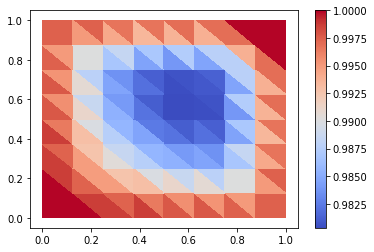

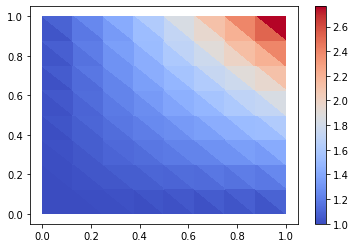

In [97]:
mesh = fd.UnitSquareMesh(4, 4)
Q = fd.FunctionSpace(mesh, 'CG', 1)

x, y = fd.SpatialCoordinate(mesh)

alpha = fd.Constant(3)
beta = fd.Constant(1.2)

t0 = 0
t = fd.Constant(t0)
T0 = fd.exp(x*y*t)
print(T0)

T_n = fd.interpolate(T0, Q)
T = fd.TrialFunction(Q)
v = fd.TestFunction(Q)
f = x*y - (y*t)**2 - (x*t)**2
dt = 0.1
k = fd.Constant(dt)
bc = fd.DirichletBC(Q, T0, 'on_boundary')



F = T*v*fd.dx + k*fd.dot(fd.nabla_grad(T), fd.nabla_grad(v))*fd.dx - (T_n + k * f)*v*fd.dx
a, L = fd.system(F)

T_ = fd.Function(Q)

while t0 < 1:
    
    fd.solve(a == L, T_, bcs=[bc])
    
    T_n.assign(T_)
    t0 += dt
    t.assign(t0)
#     bc = fd.DirichletBC(Q, T0, 'on_boundary')

    
fd.plot(T_)
T_exact = fd.interpolate(T0, Q)
fd.plot(T_exact)


In [56]:
print(bc)
bc = fd.DirichletBC(Q, T0, 'on_boundary')
print(bc)
bc2 = {'1': [bc]}
bc3 = bc2
print(bc2['1'])
print(bc3['1'])
bc3['1'].pop()
print(bc3['1'])
print(T0)
x = []
x = [T0]
print(x)

[]
exp(w_{150121} * x[0] * x[1])
[Exp(Product(Constant(FiniteElement('Real', None, 0), 150121), Product(Indexed(SpatialCoordinate(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 60046)), MultiIndex((FixedIndex(0),))), Indexed(SpatialCoordinate(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 60046)), MultiIndex((FixedIndex(1),))))))]


In [ ]:
print(T_exact.dat.data)

In [ ]:
bc = {'up' : ([1, 2], ['update', 'fixed']), 'abc' : ([3, 6], ['fixed', 'fixed'])}


In [ ]:
for key, value in bc.items():
    print(key)
    print(value)
    print(len(value[0]))
    for i in range(len(value[0])):
        if value[1][i] is 'update':
            value[0][i] *= 2

print(bc)

In [17]:
x = ((1, 2, 3), ((1,4), 2, 3))

In [24]:
print(x[0][1])

2


In [66]:
system_names = ['up']
names = ['u', 'p']
bound={}
bound = dict((name1,   dict((name2, ([], [])) for name2 in names)) for name1 in system_names)
bound.update([('c', {'c': ([], [])})])
print(bound)

{'up': {'u': ([], []), 'p': ([], [])}, 'c': {'c': ([], [])}}


In [84]:
bc_exp = ((0, 0, 0), ((1,2),2, 3))
for 


3


In [78]:
names = ['u', 'p', 'k']



for name in names:
    for key in bound:
        if name in bound[key]:
            print('yes')
    

yes
yes


In [40]:
asdf = {}
for key, value in bound['up'].items():
    asdf.update([(key, value[0])])

In [91]:
fd.DirichletBC.reconstruct?